In [1]:
from MemSE import ROOT
from MemSE.nas import AccuracyDataset
import torch
import json

memse_dataset = AccuracyDataset(ROOT / 'experiments/conference_2/results')

dataset = json.load(open( ROOT / 'experiments/conference_2/results/acc.dict'))
power_ascending = sorted(dataset.items(), key=lambda v: v[1]['power'])
pareto_front = []
raw_points = []
to_save = {}
for v in power_ascending:
    k = v[0]
    v = v[1]
    raw_points.append((v['power'], v['top1']))
    if not pareto_front:
        pareto_front.append((v['power'], v['top1']))
        to_save[v['power']] = (None, (v['top1'], json.loads(k), v['power']))
        continue
    if v['top1'] > pareto_front[-1][1]:
        pareto_front.append((v['power'], v['top1']))
        to_save[v['power']] = (None, (v['top1'], json.loads(k), v['power']))

#torch.save(to_save, f'{ROOT}/experiments/conference_2/results/ga_results_dataset.pth')

/home/sebwood/projects/def-franlp/sebwood/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
save_path = ROOT / 'experiments/conference_2/results/ga_evals_dataset.pth'
results = torch.load(save_path).values()
ga_dataset = {
    'pf': ([], []),
    'estimators': ([], [])
}
for v in results:
    ga_dataset['pf'][0].append(v['pow'][1])
    ga_dataset['pf'][1].append(v['acc'][1])
    ga_dataset['estimators'][0].append(v['pow'][0])
    ga_dataset['estimators'][1].append(v['acc'][0])

In [16]:
def process_saved(save_path):
    results = torch.load(save_path).values()
    ga_const_power_ascending = sorted(results, key=lambda v: v['pow'][1])
    ga_dataset = {
        'pf': ([], []),
        'estimators': ([], []),
        'multed': ([], [])
    }
    def treat_v(v):
        ga_dataset['pf'][0].append(v['pow'][1])
        ga_dataset['pf'][1].append(v['acc'][1])
        ga_dataset['estimators'][0].append(memse_dataset.inverse_transform_power(v['pow'][0]))
        ga_dataset['estimators'][1].append(v['acc'][0] * 100)
    for v in ga_const_power_ascending:
        if not ga_dataset['pf'][1]:
            treat_v(v)
            continue
        if v['acc'][1] > ga_dataset['pf'][1][-1]:
            treat_v(v)
    
    for sub_dict in results: # for each const optimized
        ga_dataset['multed'][0].append([])
        ga_dataset['multed'][1].append([])
        for k, v in sub_dict.items(): # acc, pow and mults dicts
            if k == 'acc' or k == 'pow':
                continue
            ga_dataset['multed'][0][-1].append(v['pow'][1])
            ga_dataset['multed'][1][-1].append(v['acc'][1])
    return ga_dataset

ga_const = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_const_AccuracyPredictor.pth')
ga_const_sigmoid = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_const_SigmoidAccuracyPredictor.pth')
ga = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_AccuracyPredictor.pth')
ga_sigmoid = process_saved(ROOT / 'experiments/conference_2/results/ga_evals_SigmoidAccuracyPredictor.pth')

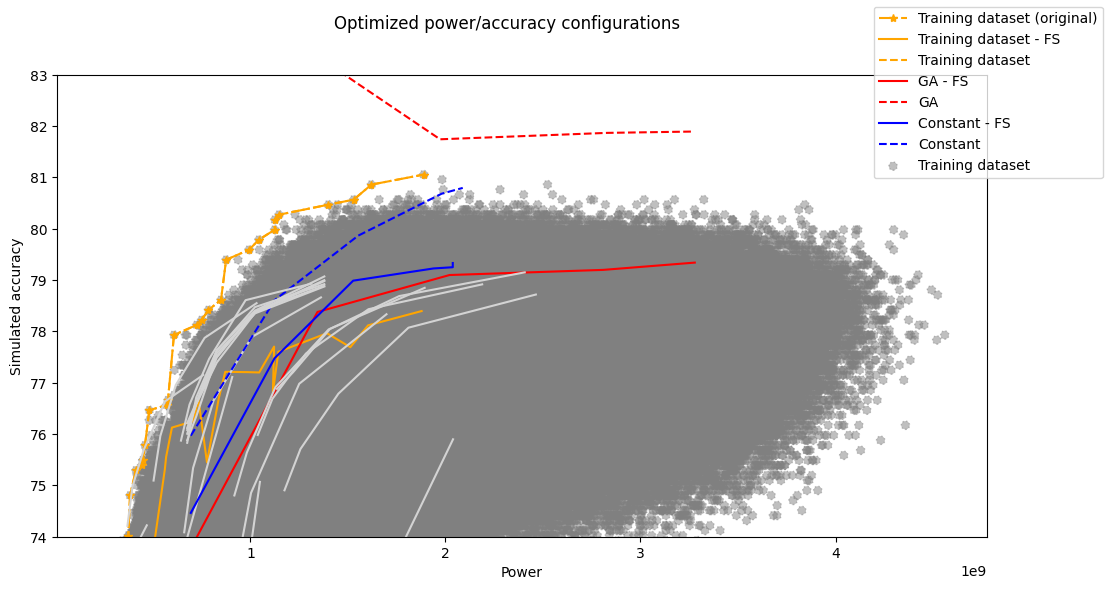

In [25]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))

def plot_dict(d, name, color):
    ax.plot(*d['pf'], label=f'{name} - FS', color=color)
    ax.plot(*d['estimators'], label=f'{name}', linestyle='--', color=color)
    if 'multed' in d:
        for i in range(len(d['multed'][0])):
            pows, accs = d['multed'][0][i], d['multed'][1][i]
            zipped = list(zip(pows, accs))
            sort_z = sorted(zipped, key=lambda x: x[0])
            ax.plot([s[0] for s in sort_z], [s[1] for s in sort_z], color='lightgray')

fig.suptitle('Optimized power/accuracy configurations')
ax.set_xlabel('Power')
ax.set_ylabel('Simulated accuracy')
ax.plot([v[0] for v in pareto_front], [v[1] for v in pareto_front], label='Training dataset (original)', linestyle='-.', color='orange', marker='*')
plot_dict(ga_dataset, name='Training dataset', color='orange')
plot_dict(ga, name='GA', color='red')
plot_dict(ga_const, name='Constant', color='blue')

# Similar performance to blue counterparts
# ax.plot([v[0] for v in ga_const_sigmoid_pareto_front], [v[1] for v in ga_const_sigmoid_pareto_front], label='GA - Gmax constant (full simulation) (S)', color='cyan')
# ax.plot([v[0] for v in ga_const_sigmoid_estimators], [v[1] for v in ga_const_sigmoid_estimators], label='GA - Gmax constant (S)', linestyle='--', color='cyan')
# ax.plot([v[0] for v in ga_sigmoid_pareto_front], [v[1] for v in ga_sigmoid_pareto_front], label='GA (full simulation) (S)', color='purple')
# ax.plot([v[0] for v in ga_sigmoid_estimators], [v[1] for v in ga_sigmoid_estimators], label='GA (S)', color='purple', linestyle='--')

ax.scatter([v[0] for v in raw_points], [v[1] for v in raw_points], label='Training dataset', color='gray', alpha=0.5, zorder=-1, linestyle=':')
fig.legend()
plt.ylim(bottom=74, top=83)
plt.show()

In [4]:
ga_pareto_front

[(657241639.95648, 73.512),
 (1343618802.11456, 78.378),
 (2020848124.96896, 79.098),
 (2808256040.71424, 79.198),
 (3278524998.12352, 79.34)]